In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)

In [6]:
filenumber=11
#folder = "./Data example"
folder = "/Users/alex/Documents/Measurements/201026 - Martin Hönig Messung/"
loadvideofile = False
if loadvideofile == False:
    dt = 0.05
    videosize = 512

pxtomum=0.0533#0.0719e-6
maxpower = 4

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14

amplitude = 1
start_time = time.time()   
if filenumber < 10:
        tdms_file = TdmsFile(folder+"/Movie_00"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Movie_00"+str(filenumber)+"_module.tdms")
else:
    if filenumber < 100:
        tdms_file = TdmsFile(folder+"/Movie_0"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Movie_0"+str(filenumber)+"_module.tdms")
    else:
        filetdms_file = TdmsFile(folder+"/Movie_"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Movie_"+str(filenumber)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

Xc = tdms_file['Data']['Xc']
Yc = tdms_file['Data']['Yc']
#velocitytheo = tdms_file['Data']['Velocity']
#angletheo = tdms_file['Data']['Angle']
xolaser = tdms_file['Data']['Xh']
yolaser = tdms_file['Data']['Yh']
Nfound = tdms_file['Data']['N']
#Nlaser = tdms_file['Data']['NLaser']
#delaywave = tdms_file['Data']['Delays']
#iterationtime = tdms_file['Data']['Iterationtime']
#programtime = tdms_file['Data']['Programtime']
#phase = tdms_file['Data']['Phase']
p = tdms_file.object().properties
#delay = int(p['Delay'])
#noise = int(p['Sigmanoise'])
#boundaryradius = p['Boundary']
offset = p['Offset']
#sigmavelo = p['Sigmavelo']
#vmin = p['Vmin']
#vmax = p['Vmax']
videosize = p['Xsize']
maxlength = len(Nfound)

if loadvideofile == True:
    dt = kinetic_cycle
    videosize = dimx
timewave=np.linspace(0,maxlength*dt,maxlength)
dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
dtframetransfer = videosize * 1.9176e-6         #time for frametransfer [s]
dtreadout = (1032/(27e6) + 1.9176e-6)*videosize #time to readout the cam [s]

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

--- 0.64 seconds ---
size of the video =  1000
length of the movie =  1000


/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)


 
Trajectory length
[999. 999. 999. 999. 999.]


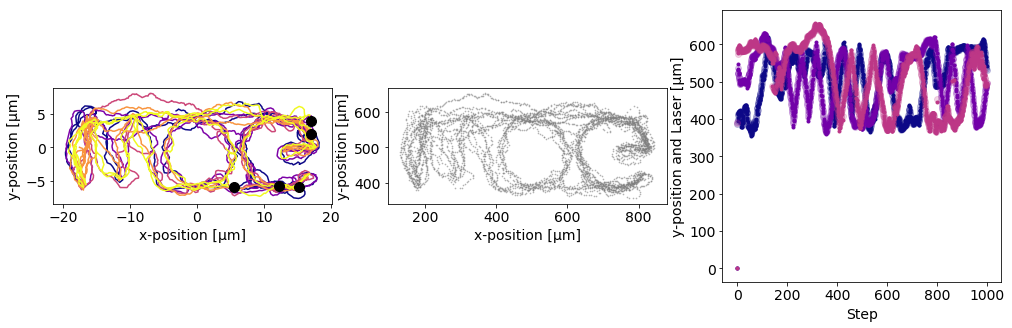

In [10]:
pnumber = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))
particles = np.zeros((maxlength,pnumber,8))
lastone = np.zeros((pnumber,2))
pre = np.zeros((maxlength,maxnumber,8))
test = np.zeros((int(Nfound[0]),2))
for i in range(int(Nfound[0])):             #Sort the particles in the first frame according to there 
    test[i,0] = i                           #distance to the center, particles outside the boundary are not important
    test[i,1] = np.sqrt(pow(Xc[i]-videosize/2,2)+pow(Yc[i]-videosize/2,2))
check = sorted(test, key=lambda test: test[1])
order = np.zeros(int(Nfound[0]))
for i in range(int(Nfound[0])):
    test2 = check[i]
    order[i] = test2[0]  
count = 0
for j in range(int(Nfound[0])):
    pre[0,j,0] = Xc[int(order[j])]
    pre[0,j,1] = Yc[int(order[j])]
count = int(Nfound[0])
for i in range(1,maxlength):               #Write all position in a first wave
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        count += 1
        
sumup = Nfound[0]                         #sumup - if the first frames are without a particle, they willbe cut off
if Nfound[0] != 0: starttraj = 0
particles[0,:,:] = pre[0,:pnumber,:]
diff = 0
for i in range(1,maxlength):
    if sumup != 0:
        check = False; occupied = np.zeros((int(Nfound[i]),2))
        for p in range(2):                    #first check those particles which where found in the frame before
            for j in range(pnumber):
                if p == 0:
                    if particles[i-1,j,0] != 0: check = True
                else:
                    if particles[i-1,j,0] == 0: check = True          
                if check == True:         
                    sumup += Nfound[i]
                    if particles[i-1,j,0] != 0:    #remember how long the particle is lost
                        lastone[j,0] = i-1
                        lastone[j,1] = 0
                    else: lastone[j,1] += 1
                    xpre = particles[int(lastone[j,0]),j,0]
                    ypre = particles[int(lastone[j,0]),j,1]
                    mindist = 50; minnum = 666
                    for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                        if occupied[k,0] == 0:
                            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                            if dist < mindist:
                                mindist = dist
                                minnum = k
                                #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,:2] = pre[i,minnum,:2]
                        occupied[minnum,0] = 1
                    
                    mindist = 0.2; minnum = 666     #sort the laser position
                    for k in range(int(Nfound[i])):
                        if particles[i,j,0] != 0:
                            if occupied[k,1] == 0:
                                dist = np.sqrt(pow(particles[i-diff,j,0]-pre[i,k,4],2)+pow(particles[i-diff,j,1]-pre[i,k,5],2))
                                #print('i = ',i,' - j = ',j,' - k = ',k,' - dist = ',round(dist,1))
                                if abs(dist - offset) < mindist:
                                    mindist = dist
                                    minnum = k
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,4:6] = pre[i,minnum,4:6]
                        occupied[minnum,1] = 1                           
    else:
        if Nfound[i] != 0:
            starttraj = i
            sumup += Nfound[i]
            for j in range(int(Nfound[i])): particles[i,j,:] = pre[i,j,:]
    #print('i = ',i,' - Nfound = ',Nfound[i],' - x[i,0] = ',int(particles[i,0,0]))

for i in range(1,maxlength):
    for j in range(pnumber):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan 
        if particles[i,j,4] == 0: 
            particles[i,j,4] = np.nan
            particles[i,j,5] = np.nan
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
particles[:,:,4:6] = (particles[:,:,4:6]-videosize/2)*pxtomum
save = particles.copy()
cutlastpoints = False
trajlength = np.zeros(pnumber)
for j in range(pnumber):
    lastfound = 0; out = True
    for i in range(starttraj+1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if lastfound+count < maxlength:
                        if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                            #print('j = ',j,' - i = ',i,' - gap = ',count)
                            check = False
                        else: count +=1
                            #print('i = ',i,' count =',count)
                    else: count += 1 #= 150
                    if count == 150:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                if out == True:
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                    #print('AFTER')
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    #print('----------')
            if i == maxlength-1: 
                trajlength[j] = i
particlessave = particles.copy()
if starttraj != 0:
    maxlength = int(maxlength-starttraj)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[starttraj:,:,:]
if cutlastpoints == True:
    particlessave = particles.copy()
    delete = maxlength - trajlength[0]
    maxlength = int(maxlength-delete)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[:maxlength,:,:]
timewave=np.linspace(0,maxlength*dt,maxlength)

print(' ')
print('Trajectory length')                  
print(trajlength)

colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (17,5) )
ax = plt.subplot(1,3,1)
ax.set_aspect('equal')
for i in range(pnumber):
    ax.scatter(particles[starttraj,i,0],particles[starttraj,i,1],color='k',s = 100,zorder=3)
    ax.plot(particles[:,i,0],particles[:,i,1],color=colorwave[i],zorder=2)
    #ax.scatter(particles[:,i,4],particles[:,i,5],color=colorwave[i],s = 30,zorder=3)
    #ax.plot(save[:,i,0],save[:,i,1],zorder=1)
#circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
#ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax2 = plt.subplot(1,3,2)
ax2.set_aspect('equal')
plt.scatter(Xc,Yc,s=0.5,color='grey',alpha = 0.5)
#circle2 = plt.Circle((videosize/2, videosize/2), boundaryradius, color='k', fill=False)
#ax2.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax3 = plt.subplot(1,3,3)
xwave = np.linspace(0,maxlength,maxlength,endpoint=False)
colorwave = cm.plasma(np.linspace(0, 1, 2*pnumber))
for j in range(3):
    ax3.scatter(xwave,pre[:,j,1],marker='o',c=colorwave[2*j],alpha=0.2)
    ax3.scatter(xwave,pre[:,j,5],marker='.',c=colorwave[2*j])
#plt.xlim([0,3000])
plt.xlabel('Step')
plt.ylabel('y-position and Laser [µm]')
plt.show()

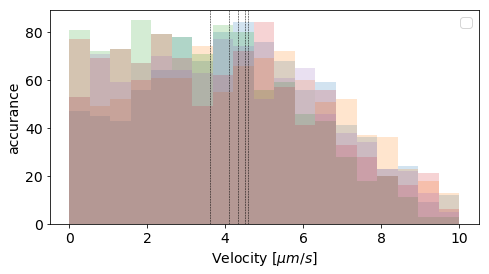

velocity particle 1 : 4.51  µm/s
velocity particle 2 : 4.57  µm/s
velocity particle 3 : 3.62  µm/s
velocity particle 4 : 4.1  µm/s
velocity particle 5 : 4.33  µm/s


In [19]:
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,pnumber));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,pnumber))
distancetocenter = np.zeros((maxlength,pnumber))

for j in range(pnumber):
    directionvector[:,0] = np.cos(particles[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        distancetocenter[i,j] = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        movingvector[i,0] = particles[i,j,0]-particles[i-1,j,0]
        movingvector[i,1] = particles[i,j,1]-particles[i-1,j,1]
        stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocity[i,j] = stepsize[i]/dt
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        
wave = velocity
binwave=np.linspace(np.amin(wave[~np.isnan(wave)]),min(np.amax(wave[~np.isnan(wave)]),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(pnumber):
    wave = velocity[:,i]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
plt.savefig('Velocities'+str(filenumber)+'.pdf', format='pdf')
plt.show() 

for i in range(pnumber): 
    wave = velocity[:,i]    
    print('velocity particle',str(i+1),':',round(np.nanmean(wave),2),' µm/s')

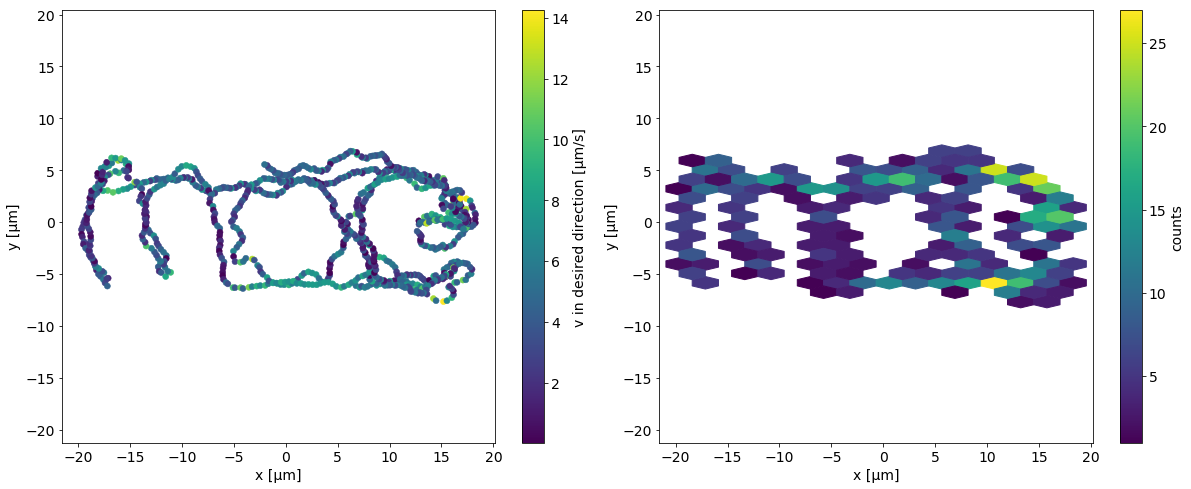

In [27]:
smoothvalue = 5
smoothit = np.zeros((maxlength,pnumber+1))
for i in range(pnumber): smoothit[:,i] = smooth(velocity[:,i],smoothvalue)
for i in range(maxlength): smoothit[i,-1] = np.mean(smoothit[i,:-1])

x = particles[:,0,0]
y = particles[:,0,1]
factor = 1.08
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
x = particles[smoothvalue:maxlength-smoothvalue,0,0]
y = particles[smoothvalue:maxlength-smoothvalue,0,1]
v = velocity[smoothvalue:maxlength-smoothvalue,0]#np.ones(maxlength)
gridsizevalue = 15
fig, axs = plt.subplots(ncols=2, figsize=(17,7), sharex='all')
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
#circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
#ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.tick_params(axis='y')
#plt.title('Particle position')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.axis('equal')
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [µm/s]')
x = particles[:,0,0]
y = particles[:,0,1]
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
#circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
#ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.axis('equal')
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(filenumber)+'.pdf', format='pdf')
plt.savefig('Path of the particle colored'+str(filenumber)+'.svg', format='svg')
plt.show()